In [1]:
#all the spark includes goes here!

from pyspark.sql import functions as F, Window
from pyspark.sql.types import StringType, IntegerType, BooleanType,DoubleType

In [2]:
#regular python includes goes in here!

import os
import re
import getpass

user = getpass.getuser()

if user == "sidsel":
    parquet = "/home/"+user+"/workspace/sparkdata/parquet/"
    regnskabsData = "alleregnskaber.parquet"
    cvrData = "virkdata.parquet"
    csvpath = "/home/"+user+'/workspace/sparkdata/csv'

elif user == "svanhmic":
    parquet = "/home/"+user+"/workspace/Python/Erhvervs/data/regnskabsdata/sparkdata/parquet/"
    regnskabsData = "alleregnskaber.parquet"
    cvrData =   "virkdata.parquet"
    csvpath = "/home/"+user+'/workspace/Python/Erhvervs/data/regnskabsdata'

print(cvrData)

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sb
import pandas as pd
import numpy as np
%matplotlib inline

virkdata.parquet


In [3]:
regnskabsDf = sqlContext.read.parquet(parquet + regnskabsData)

In [4]:
brancheWindow = Window.partitionBy("cvrNummer",F.year("gyldigFra"))

virkDf = (sqlContext
          .read
          .parquet(parquet + cvrData)
          .select("cvrNummer",F.explode("hovedbranche").alias("branche"))
          .select("cvrNummer","branche.branchekode","branche.periode.gyldigFra","branche.periode.gyldigTil","branche.branchetekst")
          #.filter(F.year(F.col("gyldigFra")) > 2008 )
          .withColumn("maxDate",F.unix_timestamp(F.col("gyldigFra"),"yyyy-MM-dd"))
          .withColumn("realBranche",F.max(F.col("maxDate")).over(brancheWindow))
          .filter(F.col("maxDate") == F.col("realBranche"))
          .orderBy("cvrNummer","gyldigFra")
          .drop("realBranche")
          .drop("maxDate")
          .withColumn("gyldigTil",F.coalesce(F.col("gyldigTil"),F.lit(F.current_date())))
         )


virkDf.show(20,False)
virkDf.printSchema()
virkDf = virkDf.se
#print(virkDf.select("branche").dtypes)
#virkDf.()
virkDf.select("branchekode").distinct().count()

+---------+-----------+----------+----------+---------------------------------------------------------+
|cvrNummer|branchekode|gyldigFra |gyldigTil |branchetekst                                             |
+---------+-----------+----------+----------+---------------------------------------------------------+
|10000009 |921100     |1999-10-12|2001-12-11|Film- og videoproduktion                                 |
|10000025 |913340     |1999-10-13|2007-12-31|Andre oplysende og kulturelle foreninger og institutioner|
|10000025 |949900     |2008-01-01|2017-04-26|Andre organisationer og foreninger i.a.n.                |
|10000068 |980000     |1999-10-18|2000-12-31|Uoplyst                                                  |
|10000068 |741490     |2001-01-01|2001-12-20|Anden virksomhedsrådgivning                              |
|10000106 |452200     |1985-07-11|2007-06-30|Tagdækningsvirksomhed                                    |
|10000122 |516410     |1999-10-14|2002-08-15|Engroshandel med ko

1535

In [5]:
def toChar(x):
    return chr(int(x))

charUdf = F.udf(lambda x: toChar(x),StringType())

signs = (regnskabsDf
           .select(F.regexp_extract(F.col("Value"),r"&#\d{1,3};",0).alias("Value"))
           .withColumn(col=charUdf(F.regexp_extract(F.col("Value"),"\d{1,3}",0)),colName="newVal")
           .filter(F.col("Value") != "")
           .dropDuplicates()
           .rdd
           .collectAsMap()
)

broadSigns = sc.broadcast(signs)

In [6]:
def replaceStuff(str):

    try:
        findings = re.findall(r'&#\d{1,3};',str)
        #findings = re.search(r'&#\d{1,3};',str)
        #print(findings)
        if findings is not None:
            for f in findings:
                str = str.replace(f,broadSigns.value[f])
        return str
    except:
        return str
        #return str
        
replaceUDf = F.udf(lambda x: replaceStuff(x),StringType())

In [7]:
aRegnskabsDf = regnskabsDf.withColumn("Value",replaceUDf(F.col("Value")))


In [8]:
powUdf = F.udf(lambda x,y: float(x) if y != None and np.abs(y) < 10 else x,DoubleType())

In [9]:
#extract turnover just to see? 
isTurnoverPresent = F.regexp_extract(F.col("Name"),r"Turnover|Revenue|GrossResult|GrossProfitLoss",0)

turnoverDf = (aRegnskabsDf
              .select('*')
              .withColumn("Turnover",F.when(isTurnoverPresent == "",0).otherwise(1))
              .filter(F.col("TurnOver") == 1)
              .withColumn("Name",F.regexp_replace(pattern=r'\w+\W',replacement="",str="Name"))
              .filter(F.col("Name") != "DescriptionOfMethodsOfRecognitionAndMeasurementBasisOfGrossProfitLoss")
              .filter(F.col("Name") != "DescriptionOfMethodsOfRecognitionAndMeasurementBasisOfRevenue")
              .filter(F.col("Name") != "DisclosureOfGrossProfitLoss")
              .filter(F.col("Name") != "DisclosureOfRevenue")
              .withColumn("Value",F.regexp_replace(pattern=",",replacement="",str=F.col("Value")).cast("float"))
              #.withColumn("Value",powUdf(F.col("Value"),F.col("Dec").cast("float")) )
              .dropDuplicates()
              .drop("Lang")
              #.drop("Dec")
              #.drop("Prec")
              .drop("originalLength")
              .drop("TurnOver")
              .cache()
             )
turnoverDf.show(5)

+-----------+---+----+-------+----------+----------------+----------+-----------+-------------+--------------------+
|       Name|Dec|Prec|unitRef|contextRef|EntityIdentifier|     Start|End_Instant|        Value|          Dimensions|
+-----------+---+----+-------+----------+----------------+----------+-----------+-------------+--------------------+
|    Revenue| -3|null|    EUR|  45349918|        45349918|2013-01-01| 2013-12-31| 1.13084403E9|[cmn:Consolidated...|
|GrossResult| -3|null|    DKK|  26559243|        26559243|2012-01-01| 2012-12-31|   -1542000.0|                  []|
|    Revenue| -3|null|    DKK|  16064939|        16064939|2013-01-01| 2013-12-31|  8.7264602E8|                  []|
|    Revenue| -6|null|    DKK|  15453613|        15453613|2015-01-01| 2015-12-31|1.49810002E10|[cmn:Consolidated...|
|    Revenue| -6|null|    DKK|  16993085|        16993085|2014-10-01| 2015-09-30| 3.50700006E9|[cmn:Consolidated...|
+-----------+---+----+-------+----------+----------------+------

In [10]:
#TEST if it has join correctly
#virkDf.filter((F.year(F.col("gyldigFra")) == 2012) & (F.year(F.col("gyldigTil")) == 2014) ).join(virkDf,("cvrNummer"),"inner").show()


In [12]:
virkDf.filter(F.col("cvrNummer")== 34900132).show()

+---------+-----------+----------+----------+------------+
|cvrNummer|branchekode| gyldigFra| gyldigTil|branchetekst|
+---------+-----------+----------+----------+------------+
| 34900132|     999999|2013-01-01|2017-04-26|     Uoplyst|
+---------+-----------+----------+----------+------------+



In [13]:
mappedCols = (turnoverDf
              .select("Name")
              .distinct()
              .rdd
              .map(lambda x: x["Name"])
              .collect()
             )

excluded = ["Dec","Prec","Lang"]
groupCols = ["unitRef","contextRef","EntityIdentifier","Start","End_Instant","Dimensions"]
maxStruct = F.struct(F.col("count"),F.col("Value"))
pivotCols = [x for x in mappedCols]

pivotDf = (turnoverDf
           .groupBy(*turnoverDf.columns)
           .count()
           .groupBy(*groupCols)
           .pivot("Name",mappedCols)
           .agg(F.max(maxStruct))
           .select(groupCols+[F.col(x+".Value").alias(x) for x in pivotCols])
           .orderBy("EntityIdentifier")
          )

In [14]:
pivotDf.show(5,truncate=False)
#pivotDf.printSchema()

+-------+----------+----------------+----------+-----------+----------+-----------+---------------+-----------------------------------------+----------------+-------+---------------------------------+
|unitRef|contextRef|EntityIdentifier|Start     |End_Instant|Dimensions|GrossResult|GrossProfitLoss|GrossProfitLossFromDiscontinuedOperations|EmployeeTurnover|Revenue|RevenueFromDiscontinuedOperations|
+-------+----------+----------------+----------+-----------+----------+-----------+---------------+-----------------------------------------+----------------+-------+---------------------------------+
|DKK    |00214239  |214239          |2013-04-01|2014-03-31 |[]        |null       |361353.0       |null                                     |null            |null   |null                             |
|DKK    |00214239  |214239          |2012-04-01|2013-03-31 |[]        |null       |358000.0       |null                                     |null            |null   |null                          

In [16]:
def containsConsolidated(col):
    try:
        for c in col:
            #print(c)
            searched = re.search(r"Consolidated",c)
            if searched.group(0):
                return True
        return False
    except AttributeError as ae:
        return False

checkConsolidatedUdf = F.udf(lambda x: containsConsolidated(x),BooleanType())

rankWindows = (Window
               .partitionBy(F.col("EntityIdentifier"))
               .orderBy(F.col("End_Instant").asc())
              )

def showCorrelationMatrix(pdf,index):
    cmap = cm.get_cmap('Spectral')
    axes = sb.pairplot(pdf, hue=index)
    
    
    #axes = pd.tools.plotting.scatter_matrix(pdf,alpha=0.5,figsize=[9,9],cmap=cmap,index=index)
    [plt.setp(item.yaxis.get_majorticklabels(), 'size', 6) for item in axes.axes.ravel()]

    #x ticklabels
    [plt.setp(item.xaxis.get_majorticklabels(), 'size', 6) for item in axes.axes.ravel()]
    [plt.setp(item.yaxis.get_label(), 'size', 6) for item in axes.axes.ravel()]

    #x labels
    [plt.setp(item.xaxis.get_label(), 'size', 6) for item in axes.axes.ravel()]
    plt.show()

In [17]:
#take out consolidated posts. 
noConsolidatedDf = (pivotDf
                    .select('*')
                    .filter(F.col("unitRef") == "DKK")
                    .filter(checkConsolidatedUdf(F.col("Dimensions")) != True)
                    .withColumn("StartYear",F.year(F.col("Start"))) # create a year column; makes it easier
                    .withColumn("rank",F.rank().over(rankWindows))
                    .withColumnRenamed(existing="EntityIdentifier",new="cvr")
                    .orderBy("cvr","rank")
                    )
#Show'em 
#noConsolidatedDf.show(5)
describeCols = mappedCols+[F.year(F.col("Start")).alias("Year")]

#Show'em summary stats
(noConsolidatedDf
 .select(describeCols)
 .describe()
 .show()
)

+-------+-------------------+--------------------+-----------------------------------------+--------------------+--------------------+---------------------------------+------------------+
|summary|        GrossResult|     GrossProfitLoss|GrossProfitLossFromDiscontinuedOperations|    EmployeeTurnover|             Revenue|RevenueFromDiscontinuedOperations|              Year|
+-------+-------------------+--------------------+-----------------------------------------+--------------------+--------------------+---------------------------------+------------------+
|  count|             325693|              533217|                                        2|                6141|              139413|                               24|            857252|
|   mean|1.154088326849282E7|  1837886.9431591434|                                      0.0|3.9872090281141676E7| 1.876623552793138E8|              7.392848716666667E7|2013.0667178379285|
| stddev|8.701859995694655E8|1.9816930996867068E9|          

In [18]:
joinStatement = ((virkDf["cvrNummer"] == noConsolidatedDf["cvr"]) & noConsolidatedDf["StartYear"].between(F.year(virkDf["gyldigFra"]),F.year(virkDf["gyldigTil"])-1))

cols = ["cvr","unitRef","contextRef","Start",
        "End_Instant","Dimensions","GrossResult",
        "GrossProfitLoss","EmployeeTurnover","Revenue","StartYear","branchekode","branchetekst","rank"]

newWindowsRank = Window.partitionBy("cvr").orderBy("StartYear")

stringTwoTruncUdf = F.udf(lambda x: str(x)[:2],StringType())
stringFourTruncUdf = F.udf(lambda x: str(x)[:4],StringType())

#create the combined dataframe for regnskabsposts and branchekoder. posts before 2010 are removed and rank is recalculated if needed!
joinedDf = (noConsolidatedDf
            .join(other=virkDf,on=joinStatement,how="left")
            #.drop("rank")
            .filter(F.col("StartYear") >= 2010) #take out pre 2010 posts. 
            .withColumn("rank",F.rank().over(newWindowsRank)) # recreate ranks
            .select(cols+[stringTwoTruncUdf("branchekode").alias("2branchekode"),stringFourTruncUdf("branchekode").alias("4branchekode")])
            .cache()
           )



#joinedDf.filter(F.col("cvr") == 10031923).orderBy("Start").show()

In [25]:
joinedDf.show()

+--------+-------+----------+----------+-----------+----------+-----------+---------------+----------------+---------+---------+-----------+--------------------+----+------------+------------+
|     cvr|unitRef|contextRef|     Start|End_Instant|Dimensions|GrossResult|GrossProfitLoss|EmployeeTurnover|  Revenue|StartYear|branchekode|        branchetekst|rank|2branchekode|4branchekode|
+--------+-------+----------+----------+-----------+----------+-----------+---------------+----------------+---------+---------+-----------+--------------------+----+------------+------------+
|10007216|    DKK|  10007216|2012-07-01| 2013-06-30|        []|   -12525.0|           null|            null|     null|     2012|     642020|Ikke-finansielle ...|   1|          64|        6420|
|10007216|    DKK|  10007216|2013-07-01| 2014-06-30|        []|   -12526.0|           null|            null|     null|     2013|     642020|Ikke-finansielle ...|   2|          64|        6420|
|10007216|    DKK|  10007216|2014-0

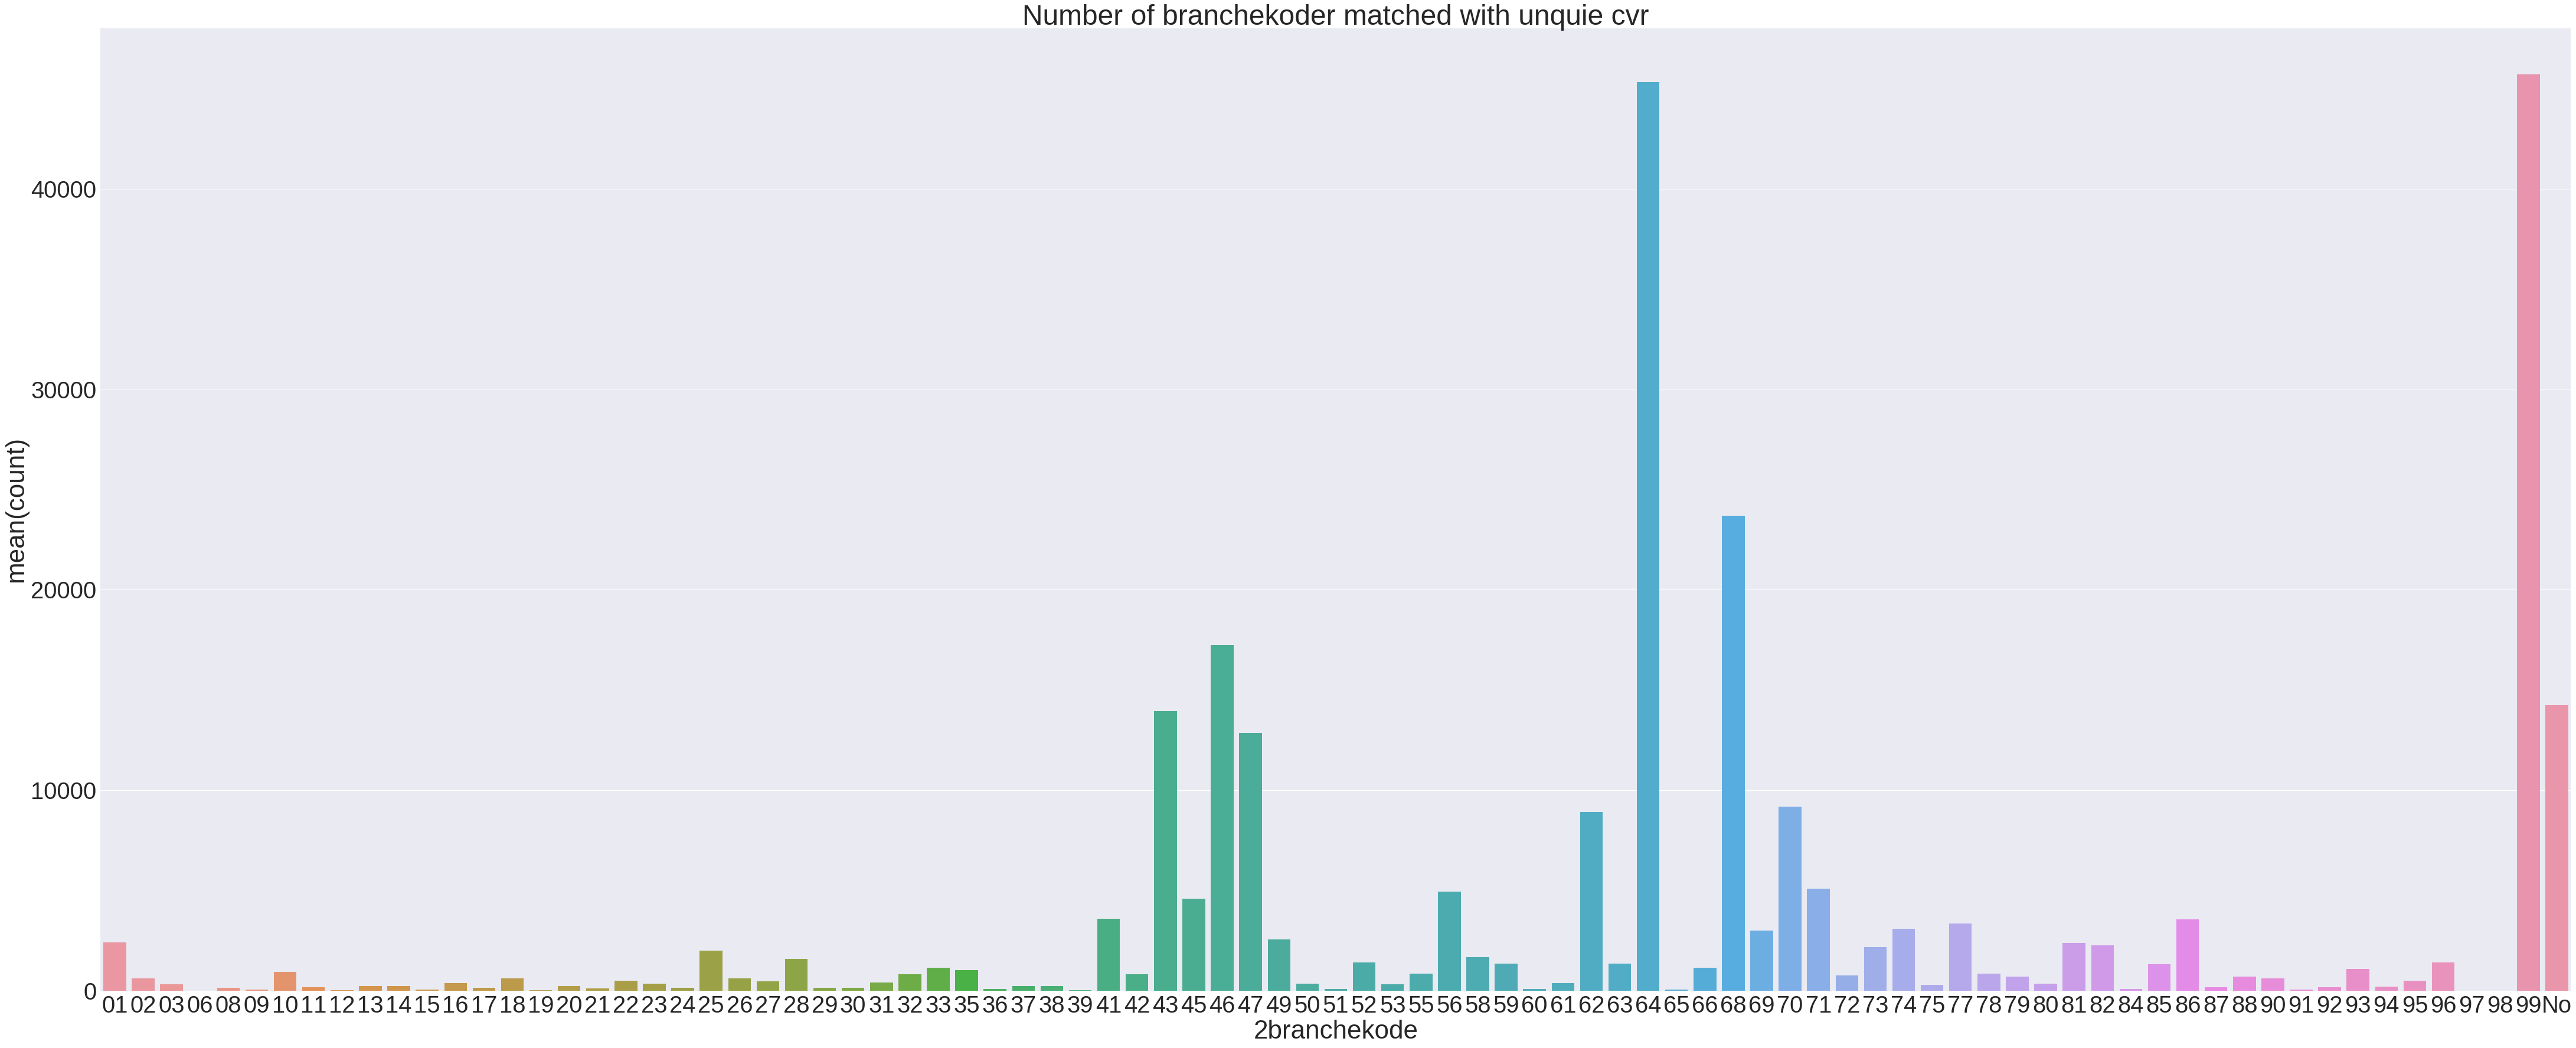

In [20]:
groupBrancherDf = joinedDf.select("cvr","2branchekode").distinct().groupBy("2branchekode").count().orderBy("2branchekode")
#groupBrancherDf.filter(F.col("count") >= 1000).orderBy("2branchekode").show(121,truncate=False)
#print(groupBrancherDf.count())


plt.figure(figsize=(75,30))
sb.set(font_scale=4)
plt.title("Number of branchekoder matched with unquie cvr")
ax = sb.barplot("2branchekode","count",data=groupBrancherDf.toPandas(),label='big') 
plt.show()
sb.set(font_scale=1)

In [30]:


brancherDf = (sqlContext
              .read
              .csv(csvpath+"/branchestruktur.csv",header=True,encoding="utf8",sep=";",nanValue=None,nullValue=None,ignoreLeadingWhiteSpace=True)
              .cache()             
             )

hovedBrancheDf = (brancherDf
                  .filter(((F.col("Hovedgruppe") != "") & (F.col("Niveau") == 1)) | (F.col("DB07") == "99.99.99"))
                  .select("Hovedgruppe","DB07","Tekst")
                  .orderBy(F.col("Hovedgruppe"))
                 )


hovedBrancheDf.show(truncate=False)

+-----------+--------+---------------------------------------------------------------------------------------------------------------+
|Hovedgruppe|DB07    |Tekst                                                                                                          |
+-----------+--------+---------------------------------------------------------------------------------------------------------------+
|null       |99.99.99|Uoplyst                                                                                                        |
|01         |null    |Plante- og husdyravl, jagt og serviceydelser i forbindelse hermed                                              |
|02         |null    |Skovbrug og skovning                                                                                           |
|03         |null    |Fiskeri og akvakultur                                                                                          |
|05         |null    |Indvinding af kul og brunkul     

In [21]:
noConsolidatedDf.groupBy("unitRef").count().show()

+-------+------+
|unitRef| count|
+-------+------+
|    DKK|857252|
+-------+------+



In [22]:
def partitionPerYear(Df, Year):
    return Df.filter(F.year("Start") == Year)


In [23]:
removeSmallAmountcols = ["GrossProfitLossFromDiscontinuedOperations","RevenueFromDiscontinuedOperations"]
includedCols = [F.log1p(f).alias(f) for f in mappedCols if f not in removeSmallAmountcols]+[F.year("Start").alias("year")]



filteredOutliersDf = (joinedDf
                      .select([i for i in joinedDf.columns if i not in removeSmallAmountcols])
                      .filter((F.year("Start") >= 2010) & (F.year("Start") < 2016))
                      .na # values that aren't there are pr. default set to 0
                      .fill(0.0,subset=[x for x in mappedCols if x not in removeSmallAmountcols])
                      .join(hovedBrancheDf,(hovedBrancheDf["Hovedgruppe"] == joinedDf["2branchekode"]),"left")
                      .drop("Hovedgruppe")
                      .drop("branchetekst")
                      .withColumnRenamed(existing="Tekst",new="branchetekst")
                     )



Based on the summery stats, we can see that: GrossProfitLossFromDiscontinuedOperations and RevenueFromDiscontinuedOperations shouldn't be regarded as variables, since they only have 2 and 24 points

We also take out outliers in years. 

#### First look at the data 
lets take a look at the correlation between these forms of revenue / profit / etc. combined with year. without other limitations. 


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:580: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:581: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


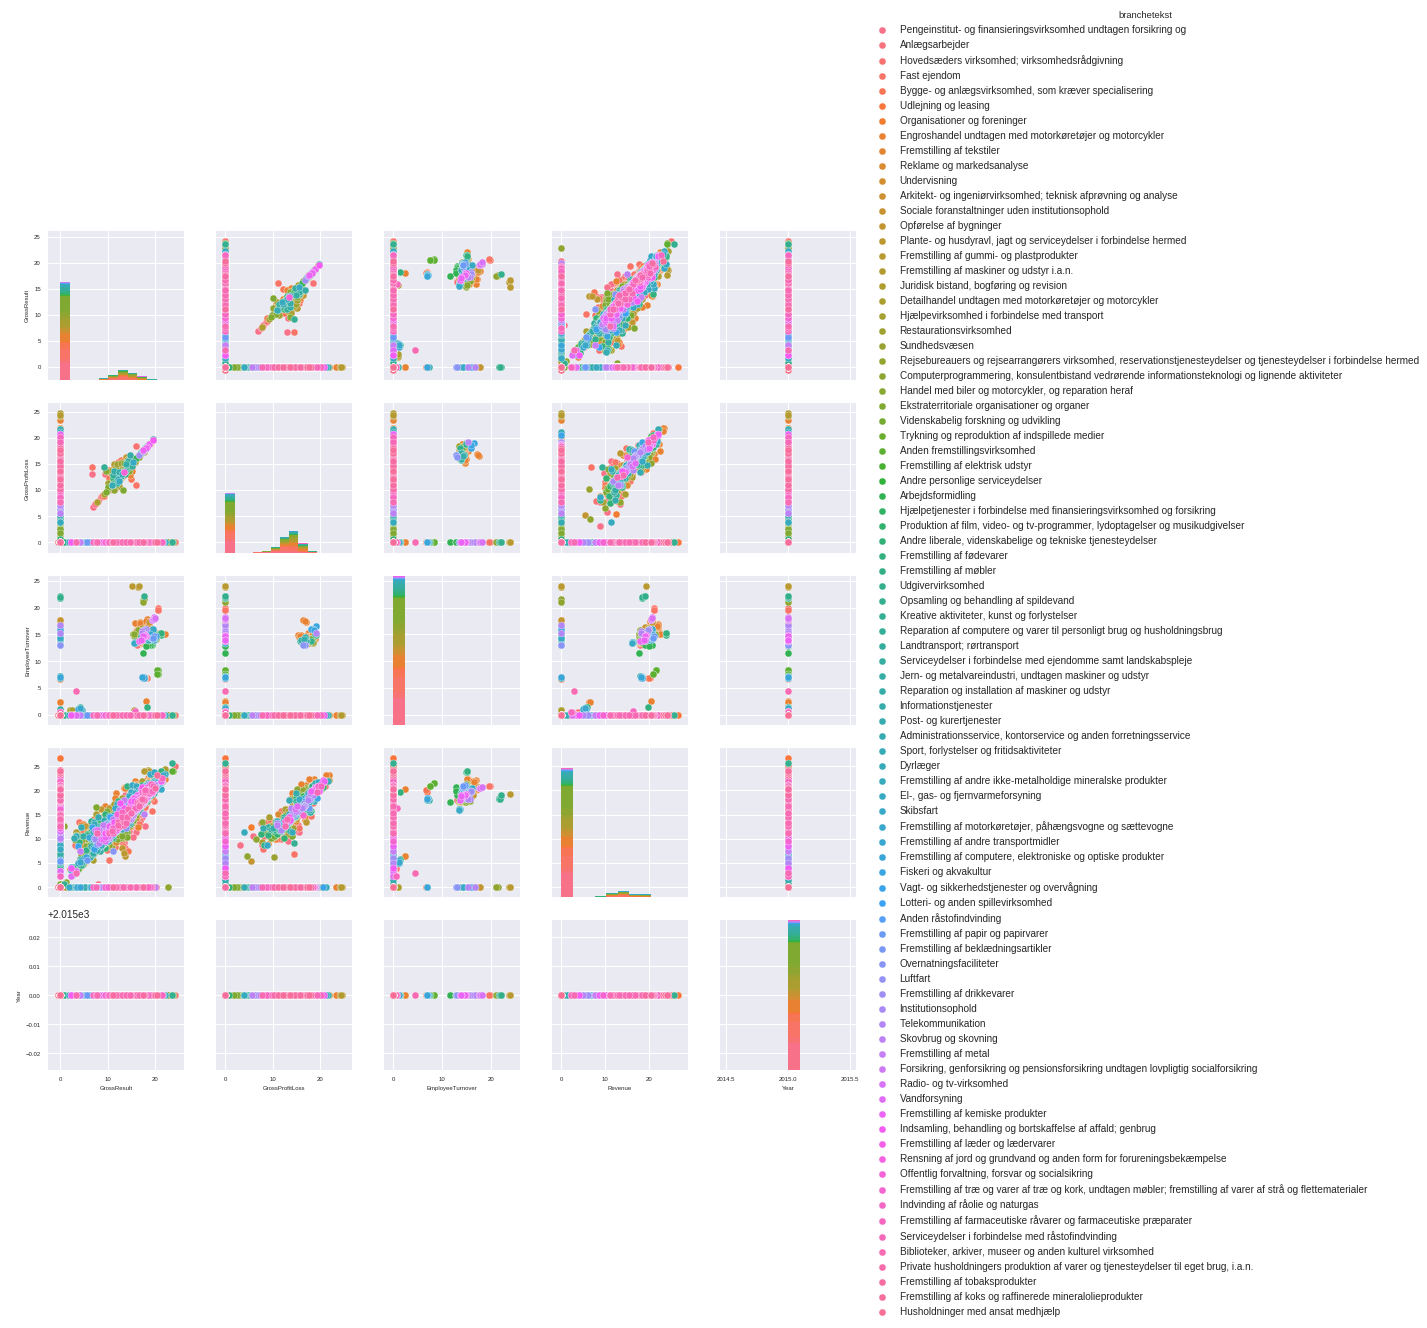

In [24]:
#filteredOutliersDf.show()

filteredOutliersDfYear = partitionPerYear(filteredOutliersDf, 2015)
scols = ["GrossResult","GrossProfitLoss","EmployeeTurnover","Revenue"]
nonNumericCols = [F.year("Start").alias("Year"),"branchetekst"]
allTogetherCols = [F.log1p(f).alias(f) for f in scols]+nonNumericCols


showCorrelationMatrix(filteredOutliersDfYear.select(allTogetherCols).toPandas(),"branchetekst")

In [25]:
cvrWindow = Window.partitionBy("cvr")
filteredOutliersDf.orderBy("cvr","rank").filter(F.col("cvr")==10002028).show()

+--------+-------+----------+----------+-----------+----------+-----------+---------------+----------------+-------+---------+-----------+----+------------+------------+------------+
|     cvr|unitRef|contextRef|     Start|End_Instant|Dimensions|GrossResult|GrossProfitLoss|EmployeeTurnover|Revenue|StartYear|branchekode|rank|2branchekode|4branchekode|branchetekst|
+--------+-------+----------+----------+-----------+----------+-----------+---------------+----------------+-------+---------+-----------+----+------------+------------+------------+
|10002028|    DKK|  10002028|2012-01-01| 2012-12-31|        []|        0.0|       -84910.0|             0.0|    0.0|     2012|     682040|   1|          68|        6820|Fast ejendom|
|10002028|    DKK|  10002028|2013-01-01| 2013-12-31|        []|        0.0|       -89008.0|             0.0|    0.0|     2013|     682040|   2|          68|        6820|Fast ejendom|
+--------+-------+----------+----------+-----------+----------+-----------+----------

Kig på branchefordeling mht employeeTurnover...

Mht indsustri 

profitloss pr ansat, se om der er en udvikling.

Undersøg udviklingen ift. hvilke brancher der stikker af. Hvordan er udviklingen pr år?


In [26]:
notloggedCols = [f for f in mappedCols if f not in removeSmallAmountcols]+[F.year("Start").alias("year")]

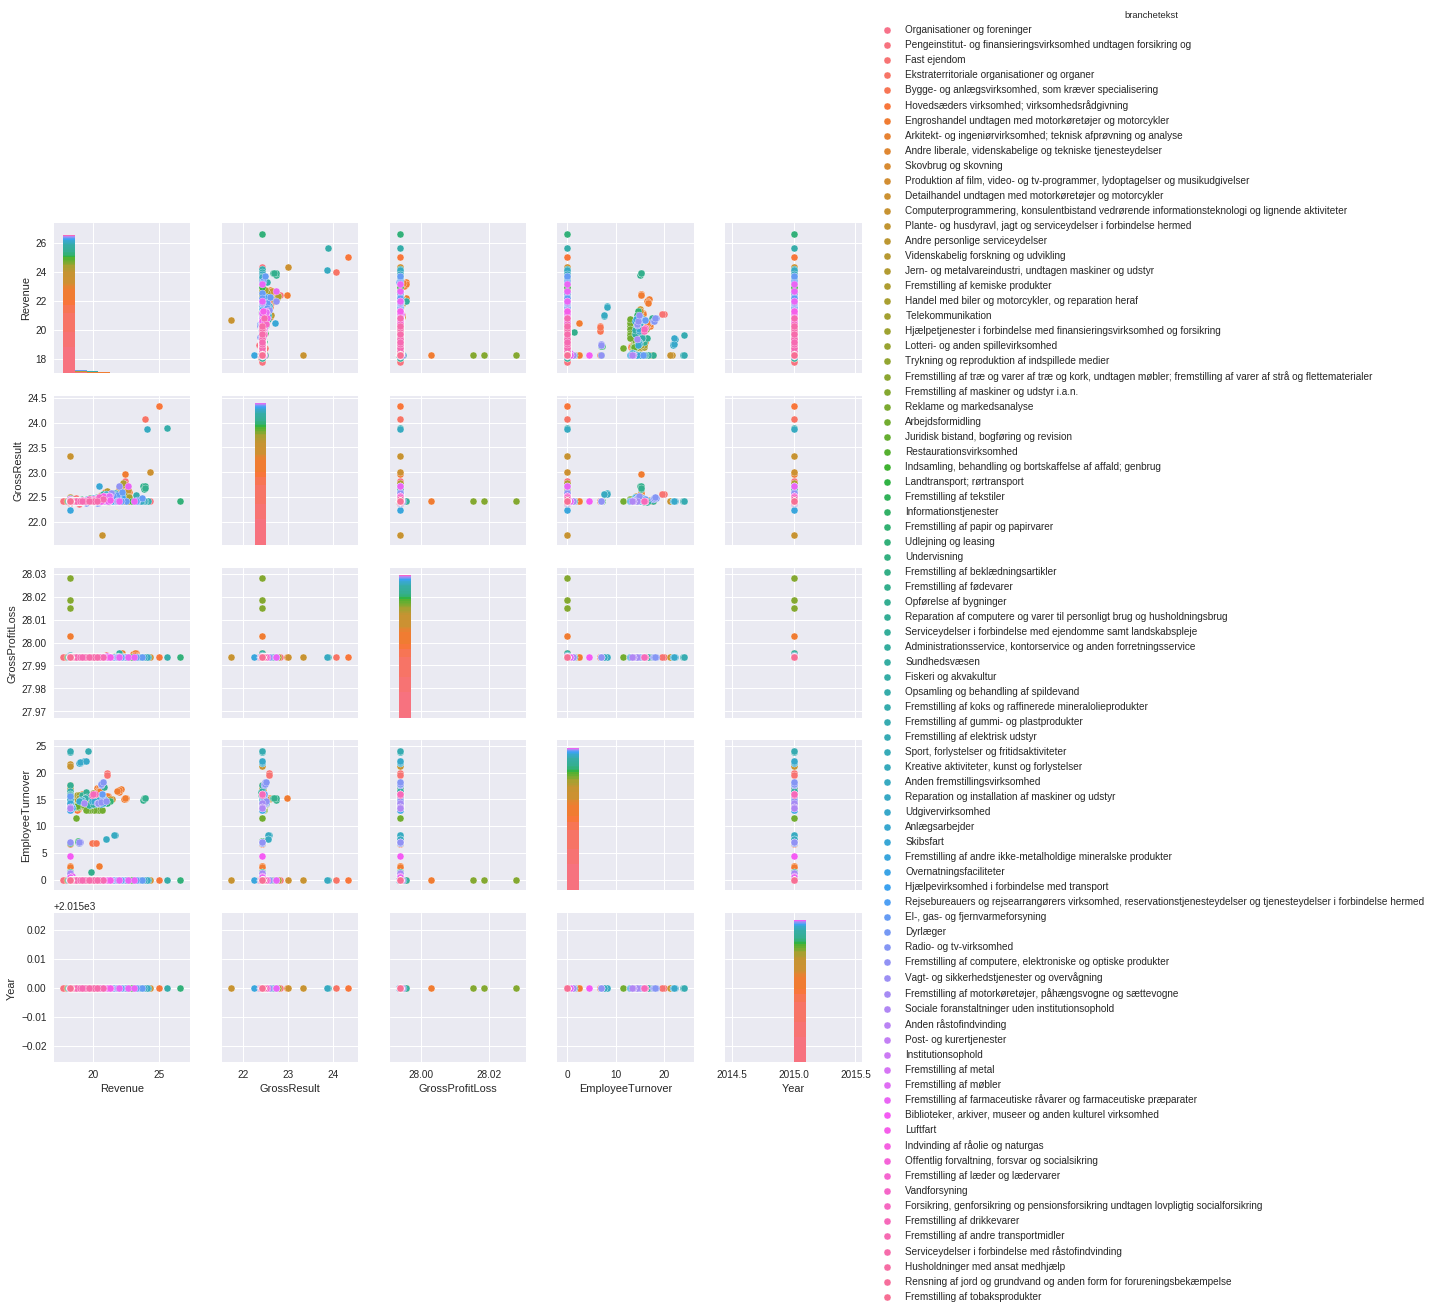

In [27]:
#Extract cvrNumbers that has more than 2 posts
aboveDf = (filteredOutliersDf
           .withColumn("maxRank",F.max("rank").over(cvrWindow))
           .filter(F.col("maxRank") > 2)
           .orderBy("cvr","rank")
           .drop("maxRank")
           .cache()
          )

#aboveDf.describe().show()
valueCols = ["Revenue","GrossResult","GrossProfitLoss","EmployeeTurnover"]

minDf = (aboveDf
         .describe()
         .filter(F.col("summary") == "min")
         .drop("rank")
         .drop("cvr")
         .drop("summary")
         .drop("StartYear")
         .select([F.col(i).cast("float").alias(i) for i in valueCols])
         .rdd
         .map(lambda x: x.asDict())
         .collect()
        )

aCols = [F.log1p(F.col(i)-F.lit(minDf[0][i])).alias(i) for i in valueCols]


showAboveDf = partitionPerYear(aboveDf.select([i for i in aboveDf.columns if i not in valueCols]+aCols),2015)
#print(showAboveDf.count())

pdf = (showAboveDf
       .select(valueCols+[F.year("Start").alias("Year"),"branchetekst"])
       #.filter((F.col("GrossResult") >= 18.5)) # we can see that there's an outlier
       .toPandas()
      )

sbplot = sb.pairplot(pdf,hue="branchetekst")
sbplot.savefig("daaah.png")

In [28]:
#We have at least 54K candidates.
aboveDf.show(5)

+--------+-------+----------+----------+-----------+----------+-----------+---------------+----------------+-------+---------+-----------+----+------------+------------+--------------------+
|     cvr|unitRef|contextRef|     Start|End_Instant|Dimensions|GrossResult|GrossProfitLoss|EmployeeTurnover|Revenue|StartYear|branchekode|rank|2branchekode|4branchekode|        branchetekst|
+--------+-------+----------+----------+-----------+----------+-----------+---------------+----------------+-------+---------+-----------+----+------------+------------+--------------------+
|10000025|    DKK|  10000025|2012-01-01| 2012-12-31|        []|        0.0|       -17101.0|             0.0|    0.0|     2012|     949900|   1|          94|        9499|Organisationer og...|
|10000025|    DKK|  10000025|2013-01-01| 2013-12-31|        []|   -24353.0|       -24353.0|             0.0|    0.0|     2013|     949900|   2|          94|        9499|Organisationer og...|
|10000025|    DKK|  10000025|2014-01-01| 2014

In [29]:
def createValsForGazeller(df,col):
    '''
        Identifies 
    '''
    mustNeverBeSmallerWindow = (Window.partitionBy("cvr").orderBy("End_Instant"))
    

    #Lets  compute the revenue...
    return (df
            .select("cvr","contextRef","branchekode","branchetekst",col,"End_Instant","rank")
            .withColumn("Lagged"+str(col),F.col(col)-F.lag(F.col(col)).over(mustNeverBeSmallerWindow))
            .na
            .fill(0.0)
           )
    
    
def isGazelle(df,col,limit):
    
    rankedWind = Window.partitionBy(F.col("cvr")).orderBy("End_Instant")
    maxWind = Window.partitionBy(F.col("cvr"))
    
    #zero criterion: start value must be equal to or higher than the minimum limit and there should be two or more posts
    #for each cvr-nummer
    startWithLimitDf = (df
                        .filter((F.col(col) >= limit))
                        #.select("cvr",col,"End_Instant","rank")
                        .withColumn("rank",F.rank().over(rankedWind))
                        .withColumn("maxRank",F.max("rank").over(maxWind))
                        .filter((F.col("maxRank") > 2))
                       )
    
    #first criterion: No post after the first must be less than the previous i.e. we always grow
    subtractedDf = (startWithLimitDf
                     .filter(F.col("Lagged"+str(col)) < 0.0)
                     .select("cvr")
                     .distinct()
                    )
    
    percent = (F.col(col)-F.first(F.col(col)).over(rankedWind))/F.first(F.col(col)).over(rankedWind)
    nonNegativeDf = (startWithLimitDf
                     .select("cvr")
                     .distinct()
                     .subtract(subtractedDf)
                     .join(startWithLimitDf,["cvr"],"inner")
                     .withColumn("factorSinceStart",percent)
                    )                                      
    #second criterion: Grown to at least double value from start to finish
    
    
    
    return (nonNegativeDf
            .withColumn("isGaz", F.when((F.col("rank") == F.col("maxRank")) & (F.col("factorSinceStart") >= 1.0),True).otherwise(False))
            .filter(F.col("isGaz") == True)
            .select("cvr")
            .distinct()
            .join(nonNegativeDf,["cvr"],"inner")
           )

In [30]:
grossProfitLossGazellerDf = createValsForGazeller(aboveDf,"GrossResult") # for grossprofitloss we have 500k
revGazellerDf = createValsForGazeller(aboveDf,"Revenue") # for grossprofitloss we have 500k

In [31]:
#aboveDf.show()
grossProfitLossGazellerDf.show(5)

+--------+----------+-----------+--------------------+-----------+-----------+----+-----------------+
|     cvr|contextRef|branchekode|        branchetekst|GrossResult|End_Instant|rank|LaggedGrossResult|
+--------+----------+-----------+--------------------+-----------+-----------+----+-----------------+
|10007216|  10007216|     642020|Pengeinstitut- og...|   -12525.0| 2013-06-30|   1|              0.0|
|10007216|  10007216|     642020|Pengeinstitut- og...|   -12526.0| 2014-06-30|   2|             -1.0|
|10007216|  10007216|     642020|Pengeinstitut- og...|   -13899.0| 2015-06-30|   3|          -1373.0|
|10007216|  10007216|     642020|Pengeinstitut- og...|        0.0| 2016-06-30|   4|          13899.0|
|10035082|  10035082|     422000|      Anlægsarbejder|        0.0| 2011-12-31|   1|              0.0|
+--------+----------+-----------+--------------------+-----------+-----------+----+-----------------+
only showing top 5 rows



In [32]:
windowMax = (Window.orderBy(F.col("FactorSinceStart").desc()).partitionBy("cvr"))
gazelleGrossDf = isGazelle(grossProfitLossGazellerDf,"GrossResult",500000)
#gazelleGrossDf.show()


print(gazelleGrossDf.select("cvr").distinct().count())

orderedGazellerDf = (gazelleGrossDf
                     .withColumn("max",F.max("FactorSinceStart").over(windowMax))
                     .orderBy(F.col("max").desc(),F.col("End_Instant"))
                     .cache()
                     )

orderedGazellerDf.drop("rank").drop("maxRank").drop("max").toPandas()#.to_csv("/home/svanhmic/gazelleGross.csv")

984


,cvr,contextRef,branchekode,branchetekst,GrossResult,End_Instant,LaggedGrossResult,factorSinceStart
0,25305639,25305639,273100,Fremstilling af elektrisk udstyr,984000.0,2013-03-31,0.0,0.000000
1,25305639,25305639,273100,Fremstilling af elektrisk udstyr,57715000.0,2015-03-31,78853000.0,57.653455
2,25305639,25305639,273100,Fremstilling af elektrisk udstyr,143724992.0,2016-03-31,86009992.0,145.061984
3,21924679,21924679,701010,Hovedsæders virksomhed; virksomhedsrådgivning,1350000.0,2013-12-31,1350000.0,0.000000
4,21924679,21924679,701010,Hovedsæders virksomhed; virksomhedsrådgivning,2061000.0,2014-12-31,2061000.0,0.526667
5,21924679,21924679,701010,Hovedsæders virksomhed; virksomhedsrådgivning,176414000.0,2015-12-31,174352992.0,129.677037
6,26383978,26383978,642020,Pengeinstitut- og finansieringsvirksomhed undt...,9125179.0,2014-09-30,9370901.0,0.000000
7,26383978,26383978,642020,Pengeinstitut- og finansieringsvirksomhed undt...,13558627.0,2015-09-30,4433448.0,0.485848
8,26383978,26383978,642020,Pengeinstitut- og finansieringsvirksomhed undt...,276515232.0,2016-09-30,262956608.0,29.302444
9,33038356,33038356,None,None,2116082.0,2012-12-31,0.0,0.000000


In [33]:
gazelleRevenueDf = createValsForGazeller(aboveDf,"Revenue") # for revenue we have 1000k
gazelleRevenueDf.show(5)

+--------+----------+-----------+--------------------+---------+-----------+----+-------------+
|     cvr|contextRef|branchekode|        branchetekst|  Revenue|End_Instant|rank|LaggedRevenue|
+--------+----------+-----------+--------------------+---------+-----------+----+-------------+
|10007216|  10007216|     642020|Pengeinstitut- og...|      0.0| 2013-06-30|   1|          0.0|
|10007216|  10007216|     642020|Pengeinstitut- og...|      0.0| 2014-06-30|   2|          0.0|
|10007216|  10007216|     642020|Pengeinstitut- og...| 284913.0| 2015-06-30|   3|     284913.0|
|10007216|  10007216|     642020|Pengeinstitut- og...|-322927.0| 2016-06-30|   4|    -607840.0|
|10035082|  10035082|     422000|      Anlægsarbejder|      0.0| 2011-12-31|   1|          0.0|
+--------+----------+-----------+--------------------+---------+-----------+----+-------------+
only showing top 5 rows



In [34]:
gazelleRevDf = isGazelle(gazelleRevenueDf,"Revenue",1000000)
gazelleRevDf.select("cvr").distinct().count()

304

In [35]:
gazelleRevDf.show(5)

+--------+----------+-----------+--------------------+---------+-----------+----+-------------+-------+-------------------+
|     cvr|contextRef|branchekode|        branchetekst|  Revenue|End_Instant|rank|LaggedRevenue|maxRank|   factorSinceStart|
+--------+----------+-----------+--------------------+---------+-----------+----+-------------+-------+-------------------+
|26010772|  26010772|     682040|        Fast ejendom|1465100.0| 2013-12-31|   1|    1465100.0|      3|                0.0|
|26010772|  26010772|       null|                null|3887003.0| 2014-12-31|   2|    2421903.0|      3| 1.6530632721315952|
|26010772|  26010772|     011100|Plante- og husdyr...|4360704.0| 2015-12-31|   3|     473701.0|      3| 1.9763865947716879|
|31943876|  31943876|     812290|Serviceydelser i ...| 1.4019E7| 2013-06-30|   1|          0.0|      4|                0.0|
|31943876|  31943876|     812290|Serviceydelser i ...| 1.9298E7| 2014-06-30|   2|    5279000.0|      4|0.37656038233825523|
+-------

In [36]:
(gazelleGrossDf
 .drop("rank")
 .drop("maxRank")
 .drop("max")
 .orderBy("cvr","End_Instant")
 .toPandas()#.to_csv("/home/svanhmic/gazelleRev.csv")
)

,cvr,contextRef,branchekode,branchetekst,GrossResult,End_Instant,LaggedGrossResult,factorSinceStart
0,10023920,10023920,731110,Reklame og markedsanalyse,1543741.0,2012-12-31,0.0,0.000000
1,10023920,10023920,None,None,2963858.0,2013-12-31,1420117.0,0.919919
2,10023920,10023920,620200,"Computerprogrammering, konsulentbistand vedrør...",2980851.0,2014-12-31,16993.0,0.930927
3,10023920,10023920,620200,"Computerprogrammering, konsulentbistand vedrør...",3096772.0,2015-12-31,115921.0,1.006018
4,10049911,10049911,620200,"Computerprogrammering, konsulentbistand vedrør...",11188000.0,2012-12-31,0.0,0.000000
5,10049911,10049911,620200,"Computerprogrammering, konsulentbistand vedrør...",18228702.0,2013-12-31,7040702.0,0.629308
6,10049911,10049911,620200,"Computerprogrammering, konsulentbistand vedrør...",20938000.0,2014-12-31,2709298.0,0.871469
7,10049911,10049911,620200,"Computerprogrammering, konsulentbistand vedrør...",28801440.0,2015-12-31,7863440.0,1.574315
8,10062845,10062845,682030,Fast ejendom,23386000.0,2012-12-31,0.0,0.000000
9,10062845,10062845,682030,Fast ejendom,53866000.0,2013-12-31,53866000.0,1.303344


### Next up:byg en regressionsmodel over gazellerne...


    
* Ide: Kig på gæld, indrag gæld som en feature.
* Ide: Kig på aktiver. Hvilke aktiver skal medtages, hvilke henvender sig især til Revenue og Bruttoresultat?
* Ide: Det kigger vi på? 


Giv Andreas Aarhus en gazelle liste.




#### IKT - brancher

In [37]:


iktBrancheDf = (sqlContext
                .read
                .csv(csvpath+"/Branche.csv",header=True,encoding="utf8",sep=";",nanValue=None,nullValue=None,ignoreLeadingWhiteSpace=True)
                .withColumn("Branchekode",F.regexp_replace(pattern="\.",replacement="",str=F.col("Branchekode")))
                .withColumnRenamed("Branchekode","branchekode")
                .cache()             
             )

iktBrancheDf.show()

+-----------+--------------------+---------------------+--------------------+
|branchekode|         Branchenavn|Standardgruppering 19|         IKT-områder|
+-----------+--------------------+---------------------+--------------------+
|     261100|Fremstilling af e...| Industri, råstofi...|        IKT-industri|
|     261200|Fremstilling af p...| Industri, råstofi...|        IKT-industri|
|     262000|Fremstilling af c...| Industri, råstofi...|        IKT-industri|
|     263000|Fremstilling af k...| Industri, råstofi...|        IKT-industri|
|     264000|Fremstilling af e...| Industri, råstofi...|        IKT-industri|
|     268000|Fremstilling af m...| Industri, råstofi...|        IKT-industri|
|     465100|Engroshandel med ...| Handel og transpo...|    IKT-Engroshandel|
|     465210|Engroshandel med ...| Handel og transpo...|    IKT-Engroshandel|
|     611000|Fastnetbaseret te...| Information og ko...|   Telekommunikation|
|     612000|Trådløs telekommu...| Information og ko...|   Telek

In [38]:
#Get a list of cvr-numbers in the IKT-world
IktGazellerGrossDf = (gazelleGrossDf
                      .withColumnRenamed(existing="GrossResult",new="Value")
                      .withColumnRenamed(existing="LaggedGrossResult",new="LaggedValue")
                      .join(iktBrancheDf,["branchekode"],"inner"))

IktGazellerRevDf = (gazelleRevDf
                    .withColumnRenamed(existing="Revenue",new="Value")
                    .withColumnRenamed(existing="LaggedRevenue",new="LaggedValue")
                    .join(iktBrancheDf,["branchekode"],"inner"))

IktGazellerDf = IktGazellerGrossDf.unionAll(IktGazellerRevDf)

In [39]:
IktBrancheDf = (filteredOutliersDf
                .drop("contextRef")
                .drop("Start")
                .drop("Dimensions")
                .drop("2branchekode")
                .drop("4branchekode")
                .drop("StartYear")    
                .drop("EmployeeTurnover")
                .join(iktBrancheDf,["branchekode"], "inner"))

IktNotGazellerDf = (IktBrancheDf
                    .select("cvr")
                    .distinct()
                    .subtract(IktGazellerDf.select("cvr"))
                    .join(IktBrancheDf, ("cvr")))
                    
#IktNotGazellerDf.count()

#print(IktGazellerGrossDf.count())
#print(IktGazellerRevDf.count())

#IktGazellerDf.count()

In [83]:
GazelleCVRsDf = IktGazellerDf.select("cvr").distinct().rdd.map(lambda x: x[0]).collect()
IktBrancheDf = (IktBrancheDf[IktBrancheDf.cvr.isin(*GazelleCVRsDf)]
                   .withColumn("isGazelle",F.lit(1))
                   .unionAll(IktBrancheDf[~IktBrancheDf.cvr.isin(*GazelleCVRsDf)].withColumn("isGazelle",F.lit(0))))

In [106]:
IktBrancheDf.select("cvr","isGazelle").distinct().filter(F.col("isGazelle")==0).count()

12563

41410


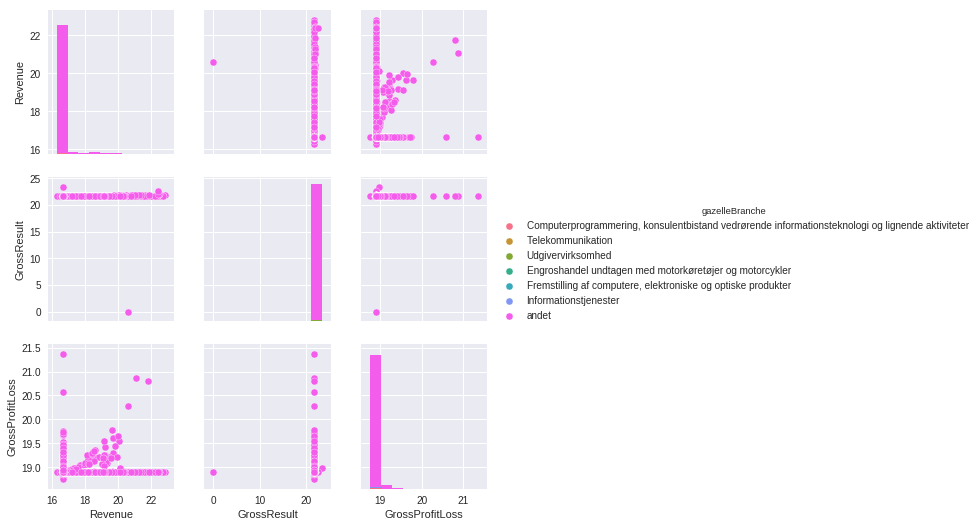

In [102]:
valueCols = ["Revenue","GrossResult","GrossProfitLoss"]

minDf = (IktBrancheDf
         .describe()
         .filter(F.col("summary") == "min")
         .select([F.col(i).cast("float").alias(i) for i in valueCols])
         .rdd
         .map(lambda x: x.asDict())
         .collect()
        )

aCols = [F.log1p(F.col(i)-F.lit(minDf[0][i])).alias(i) for i in valueCols]

IktBranche2Df = IktBrancheDf.withColumnRenamed(new="Start",existing="End_Instant")
IktBranche2Df = IktBranche2Df.select("*", F.when(F.col("isGazelle")==True, F.col("branchetekst")).otherwise("andet").alias("gazelleBranche"))
showAboveDf = partitionPerYear(IktBranche2Df.select([i for i in IktBranche2Df.columns if i not in valueCols]+aCols),2015)
print(IktBranche2Df.count())

pdf = (showAboveDf
       .select(valueCols+["Start","gazelleBranche"])
       #.filter((F.col("GrossResult") >= 18.5)) # we can see that there's an outlier
       .toPandas()
      )

sbplot = sb.pairplot(pdf,hue="gazelleBranche")

In [41]:
IktGazellerDf.show(5)

+-----------+--------+----------+--------------------+-----------+-----------+----+-----------+-------+-------------------+--------------------+---------------------+--------------------+
|branchekode|     cvr|contextRef|        branchetekst|      Value|End_Instant|rank|LaggedValue|maxRank|   factorSinceStart|         Branchenavn|Standardgruppering 19|         IKT-områder|
+-----------+--------+----------+--------------------+-----------+-----------+----+-----------+-------+-------------------+--------------------+---------------------+--------------------+
|     620900|32943071|  32943071|Computerprogramme...|   661745.0| 2012-12-31|   1|        0.0|      3|                0.0|Anden it-servicev...| Information og ko...|IKT-service, kons...|
|     620900|32943071|  32943071|Computerprogramme...|  1446868.0| 2013-12-31|   2|   785123.0|      3|  1.186443418537352|Anden it-servicev...| Information og ko...|IKT-service, kons...|
|     620900|32943071|  32943071|Computerprogramme...|  2577

In [42]:
IktNotGazellerDf.show(5)

+--------+-----------+-------+-----------+-----------+---------------+-------+----+--------------------+--------------------+---------------------+--------------------+
|     cvr|branchekode|unitRef|End_Instant|GrossResult|GrossProfitLoss|Revenue|rank|        branchetekst|         Branchenavn|Standardgruppering 19|         IKT-områder|
+--------+-----------+-------+-----------+-----------+---------------+-------+----+--------------------+--------------------+---------------------+--------------------+
|14674748|     620200|    DKK| 2013-04-30|        0.0|      1046152.0|    0.0|   1|Computerprogramme...|Konsulentbistand ...| Information og ko...|IKT-service, kons...|
|14674748|     620200|    DKK| 2014-04-30|        0.0|      1045268.0|    0.0|   2|Computerprogramme...|Konsulentbistand ...| Information og ko...|IKT-service, kons...|
|14674748|     620200|    DKK| 2015-04-30|        0.0|       890411.0|    0.0|   3|Computerprogramme...|Konsulentbistand ...| Information og ko...|IKT-serv

In [43]:
IktGazellerDf.withColumnRenamed(existing="Standardgruppering 19",new="Standardgruppering_19").write.mode("overwrite").parquet(os.path.join(parquet, 'IktGazeller'))
IktBrancheDf.withColumnRenamed(existing="Standardgruppering 19",new="Standardgruppering_19").write.mode("overwrite").parquet(os.path.join(parquet, 'IktBrancher'))
IktNotGazellerDf.withColumnRenamed(existing="Standardgruppering 19",new="Standardgruppering_19").write.mode("overwrite").parquet(os.path.join(parquet, 'IktNotGazeller'))
